In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

In [42]:
cities = ['ABZ', 'ALE', 'AMA', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'DEL', 'EGB',
          'HAD', 'HEL', 'HPB', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 'MLP', 'MUK', 
          'NAN', 'NEU', 'POV', 'SAO', 'SCH', 'SGP', 'UAE', 'VAR', 'VIE', 'WAL', 'ZOT']

variables = ['aermr_seasalt', 'aermr01', 'aermr02', 'aermr03', 
             'aermr_dust', 'aermr04', 'aermr05', 'aermr06',
             'aermr_om', 'aermr07', 'aermr08', 'aermr_ombc', 'aermr_bc', 'aermr09', 'aermr10', 
             'co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2', 'd2m', 't2m', 
             'crwc', 'blh', 'rh', 'doy_sin', 'doy_cos', 'latitude', 'longitude_sin', 'longitude_cos']

dont_transform = ['d2m', 't2m', 'blh', 'rh', 'doy_sin', 'doy_cos', 'latitude', 'longitude_sin', 'longitude_cos']
transf_vars = []
for v in variables:    
    if v in dont_transform:
        transf_vars.append(v)
    else:
        transf_vars.append(v+'_log')

In [35]:
# loading the data
data = pd.read_csv('data/full_data.csv', parse_dates=['date'])

# log-transformed values that are < 1 become negative, which doesn't make sense
data.loc[data.n100 < 1, 'n100'] = 1

# adding variables that aggregate the mixing ratios for the same type of aerosol
data['aermr_seasalt'] = data['aermr01'] + data['aermr02'] + data['aermr03']
data['aermr_dust'] = data['aermr04'] + data['aermr05'] + data['aermr06']
data['aermr_om'] = data['aermr07'] + data['aermr08']
data['aermr_bc'] = data['aermr09'] + data['aermr10']
data['aermr_ombc'] = data['aermr07'] + data['aermr08'] + data['aermr09'] + data['aermr10']

# log-transforming selected variables
for v in ['n100']+variables:
    if v not in dont_transform:
        transformed = data[v]
        transformed = transformed.where(transformed > 0, transformed[transformed > 0].min())
        data[v+'_log'] = np.log(transformed)
        
data.head()

,id,station,date,doy_sin,doy_cos,latitude,longitude_sin,longitude_cos,n100,aermr01,...,aermr_ombc_log,aermr_bc_log,co_log,c5h8_log,c10h16_log,nh3_log,no_log,no2_log,so2_log,crwc_log
0,ABZ-2012-01-26,ABZ,2012-01-26,0.431673,0.902030,0.561889,0.438057,0.898947,2708.085714,6.752697e-12,...,-17.587720,-21.015460,-14.888857,-24.715712,-22.277308,-20.891909,-18.156078,-17.697916,-18.856889,-24.916861
1,ABZ-2012-01-27,ABZ,2012-01-27,0.447094,0.894487,0.561889,0.438057,0.898947,2489.175000,4.223335e-12,...,-17.242244,-20.821714,-14.786466,-24.526129,-22.109902,-20.714570,-18.022533,-17.632291,-18.761336,-24.916861
2,ABZ-2012-01-28,ABZ,2012-01-28,0.462383,0.886680,0.561889,0.438057,0.898947,3484.229167,3.553853e-12,...,-16.938109,-20.498733,-14.472229,-24.080899,-21.518834,-20.381543,-17.223582,-17.785600,-18.708921,-24.916861
3,ABZ-2012-01-29,ABZ,2012-01-29,0.477536,0.878612,0.561889,0.438057,0.898947,2977.512500,8.665312e-12,...,-17.375509,-20.685265,-14.977114,-25.068593,-22.885339,-20.340459,-19.236020,-17.969860,-19.128033,-24.916861
4,ABZ-2012-01-30,ABZ,2012-01-30,0.492548,0.870285,0.561889,0.438057,0.898947,2702.463636,1.436837e-11,...,-17.646410,-20.878525,-15.236442,-25.461374,-23.836271,-20.333199,-20.702253,-18.124264,-19.070916,-24.916861


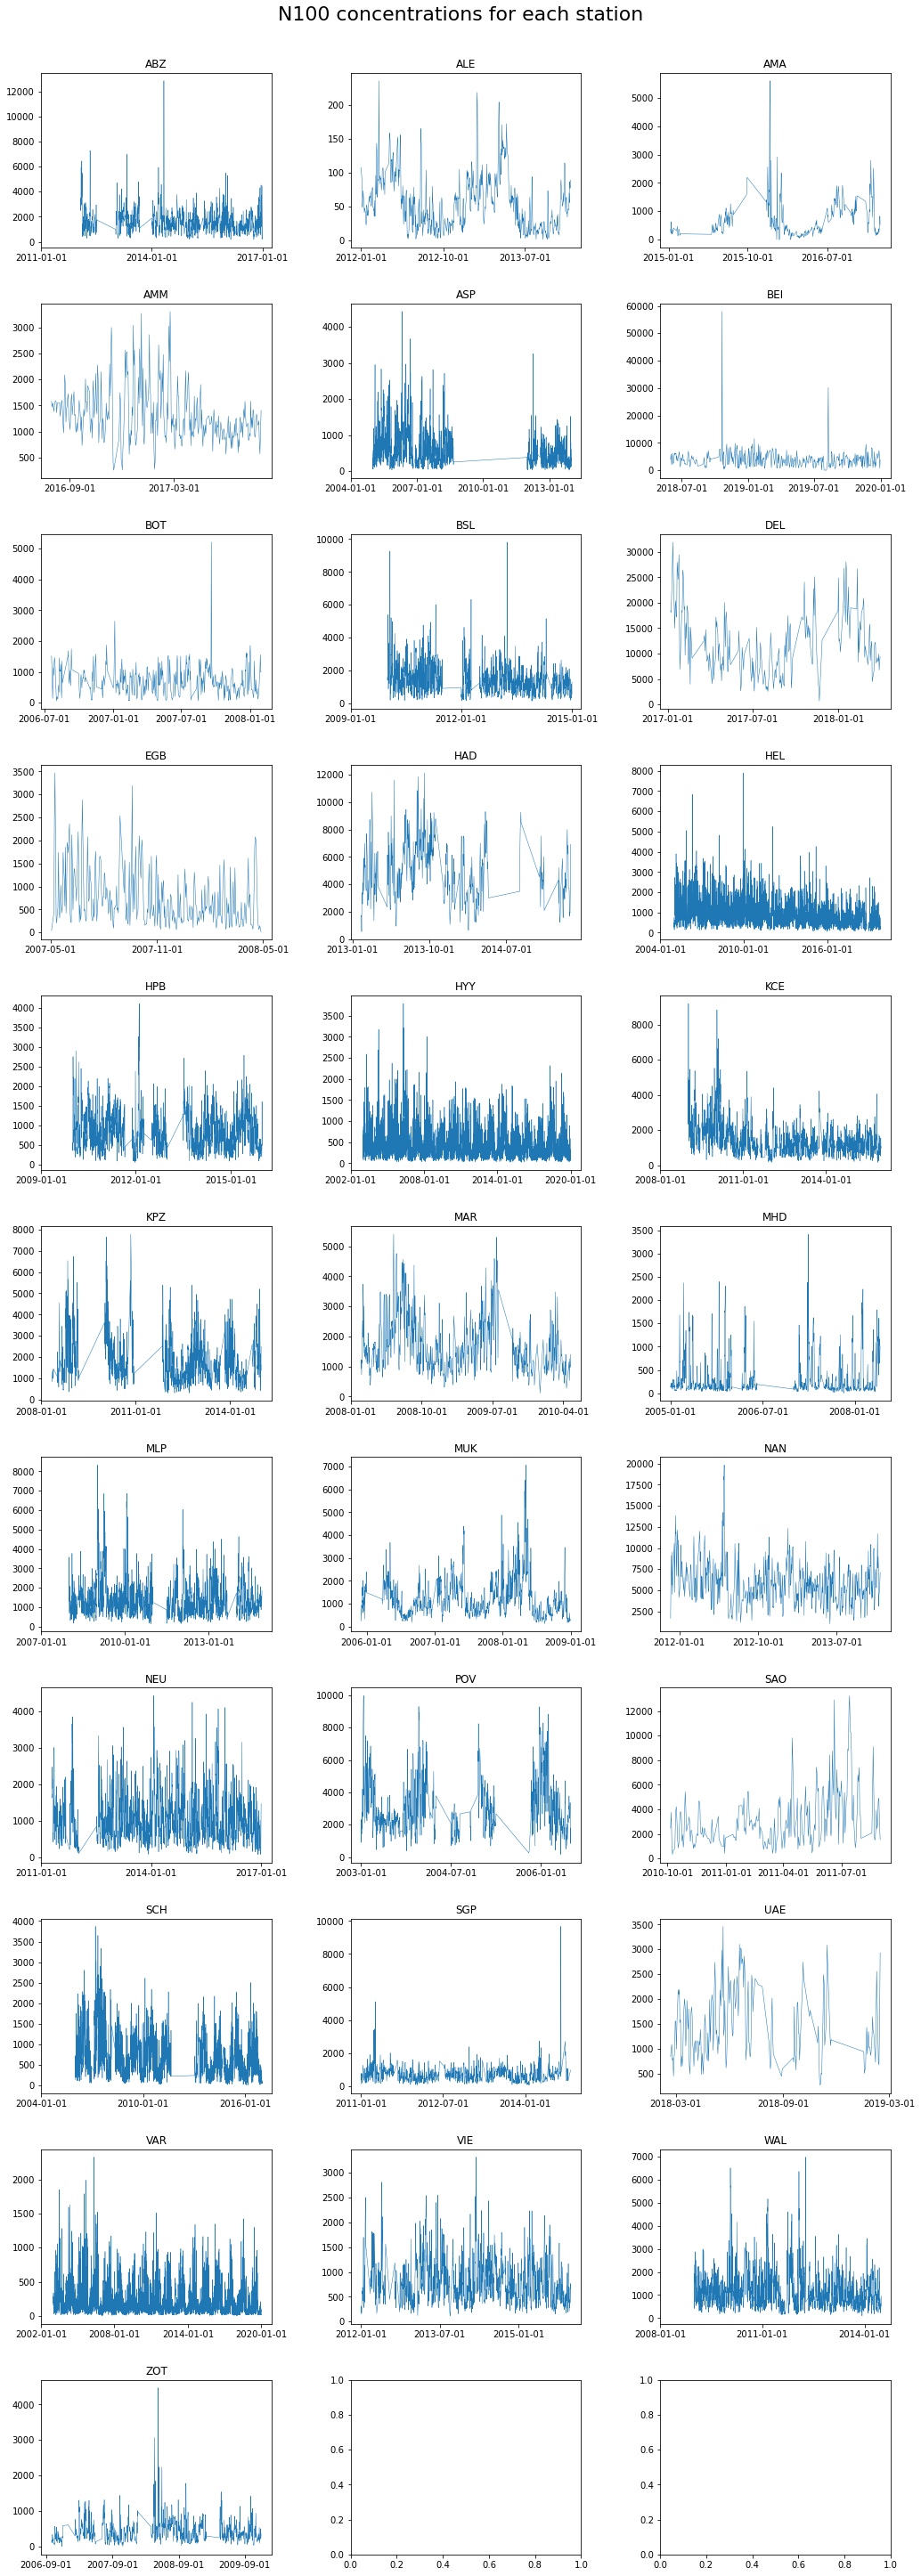

In [50]:
fig, axes = plt.subplots(11, 3, figsize=(15,40))
axes = iter(axes)
i = 0

for c in cities:
    if i%3 == 0:
        axis = next(axes)
    ax = axis[i%3]
    ax.plot(data.date.loc[data.station == c], data.n100.loc[data.station == c], lw=0.5)
    ax.set_title(c)
    ax.set_xticks(ax.get_xticks()[::3])
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('N100 concentrations for each station', y=1.01, fontsize=22);

In [39]:
variable_dict = {'n100': 'N100 concentration',
                 'aermr_seasalt': 'Sea salt aerosol (0.03 - 20 µm)\nmixing ratio', 
                 'aermr01': 'Sea salt aerosol (0.03 - 0.5 µm)\nmixing ratio',
                 'aermr02': 'Sea salt aerosol (0.5 - 5 µm)\nmixing ratio',
                 'aermr03': 'Sea salt aerosol (5 - 20 µm)\nmixing ratio',
                 'aermr_dust': 'Dust aerosol (0.03 - 20 µm)\nmixing ratio', 
                 'aermr04': 'Dust aerosol (0.03 - 0.55 µm)\nmixing ratio',
                 'aermr05': 'Dust aerosol (0.55 - 0.9 µm)\nmixing ratio',
                 'aermr06': 'Dust aerosol (0.9 - 20 µm)\nmixing ratio',
                 'aermr_om': 'Organic matter\naerosol mixing ratio', 
                 'aermr07': 'Hydrophilic organic matter\naerosol mixing ratio',
                 'aermr08': 'Hydrophobic organic matter\naerosol mixing ratio',
                 'aermr_ombc': 'Organic matter and black carbon\naerosol mixing ratio', 
                 'aermr_bc': 'Black carbon\naerosol mixing ratio',
                 'aermr09': 'Hydrophilic black carbon\naerosol mixing ratio',
                 'aermr10': 'Hydrophobic black carbon\naerosol mixing ratio',
                 'co': 'Carbon monoxide',
                 'c5h8': 'Isoprene',
                 'c10h16': 'Terpenes',
                 'nh3': 'Ammonia',
                 'no': 'Nitrogen monoxide',
                 'no2': 'Nitrogen dioxide',
                 'so2': 'Sulphur dioxide',
                 'd2m': 'Dew point temperature\nat 2m height',
                 't2m': 'Air temperature\nat 2m height',
                 'crwc': 'Specific rain water content',
                 'blh': 'Boundary layer height',
                 'rh': 'Relative humidity',
                 'doy_sin': 'Sine of the day of the year',
                 'doy_cos': 'Cosine of the day of the year',
                 'latitude': 'Latitude',
                 'longitude_sin': 'Sine of longitude',
                 'longitude_cos': 'Cosine of longitude'}

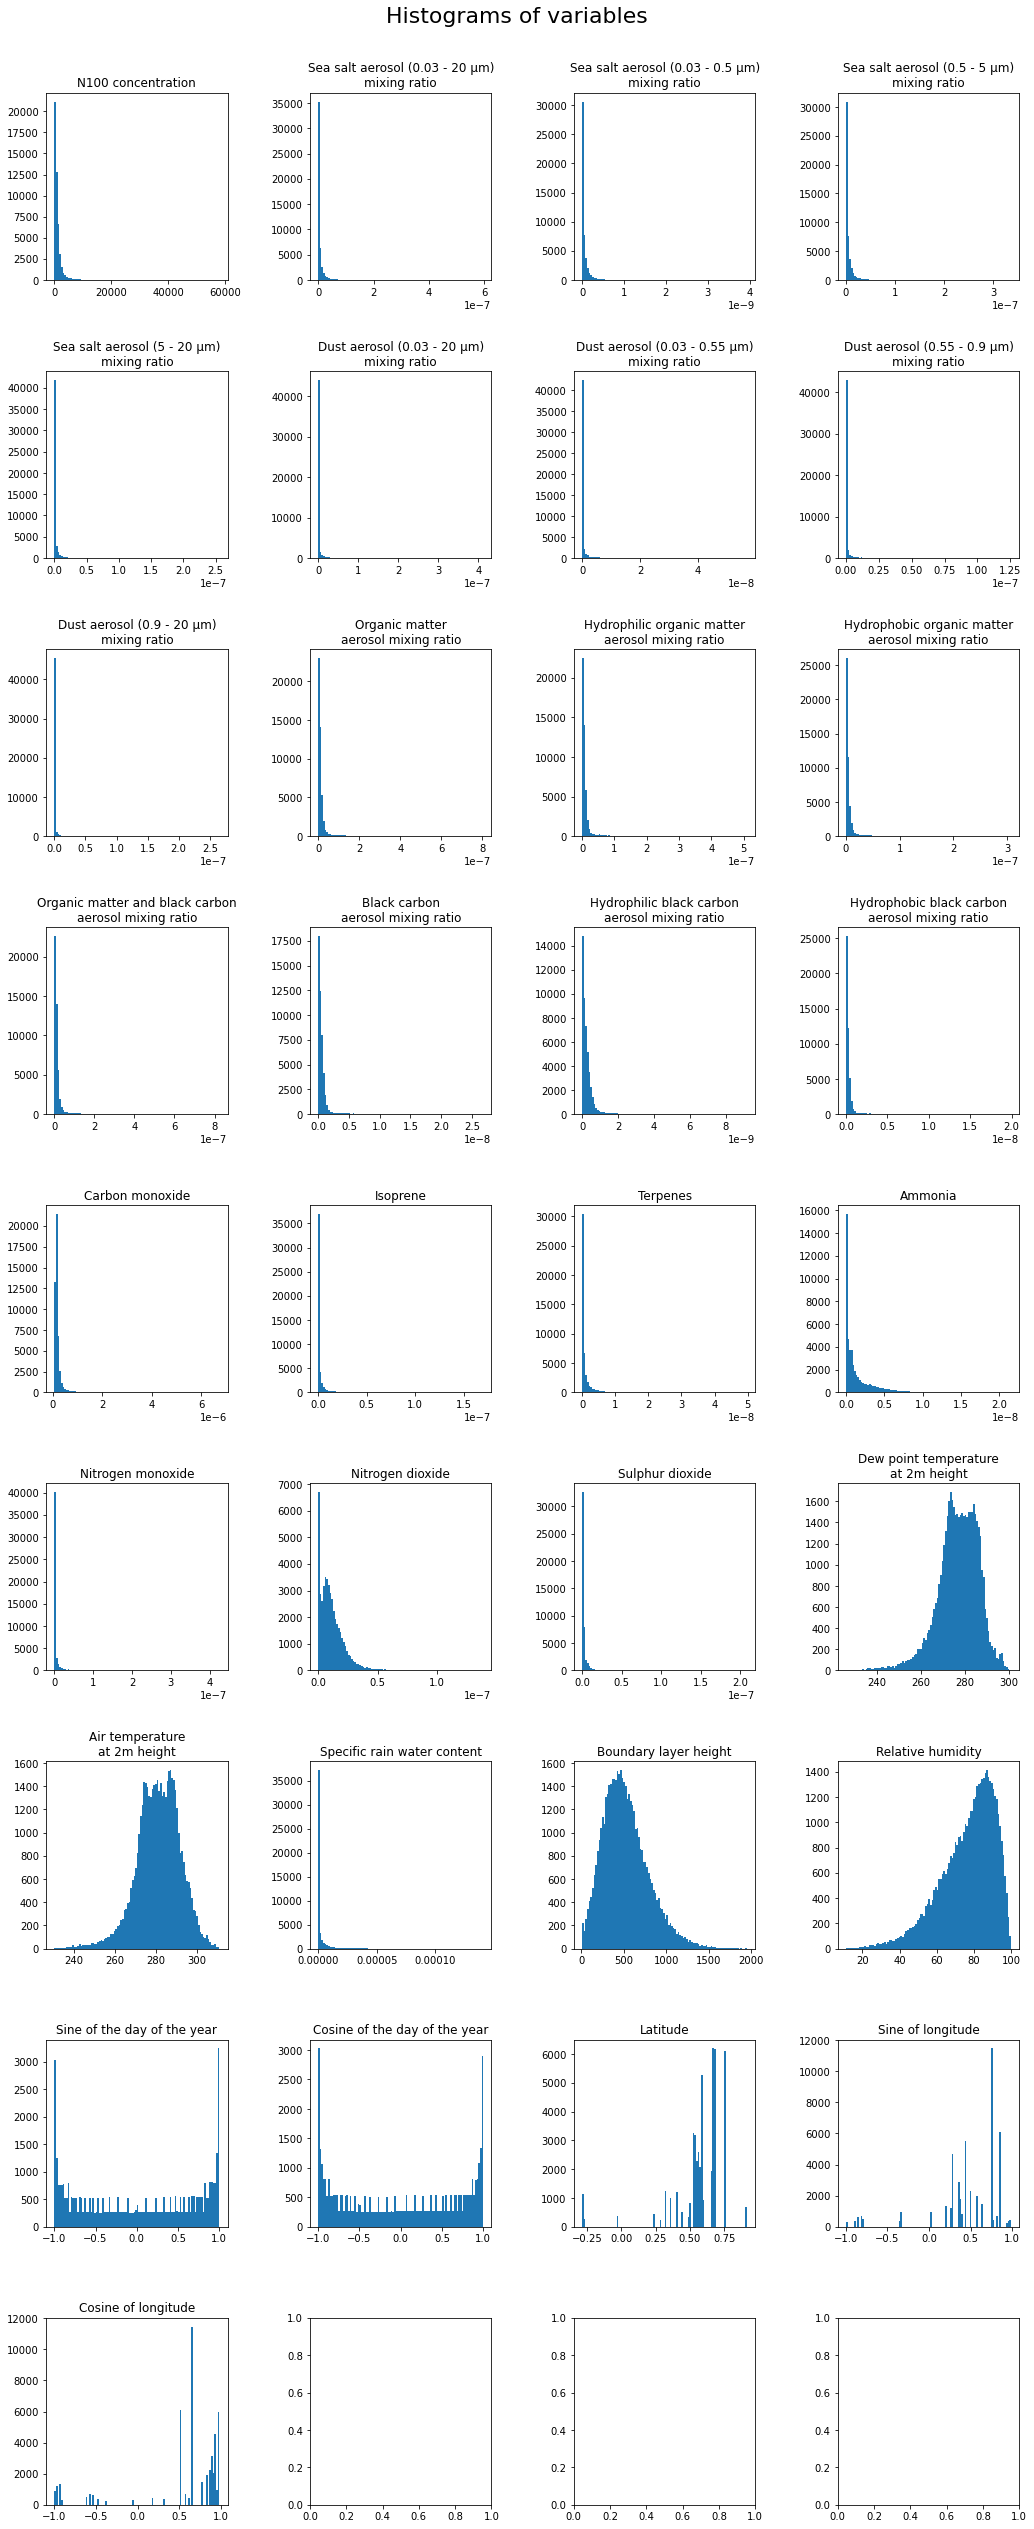

In [43]:
ncols = 4
fig, axes = plt.subplots(9, ncols, figsize=(15,35))
axes = iter(axes)
i = 0

for v in ['n100']+variables:
    if i%ncols == 0:
        axis = next(axes)
    ax = axis[i%ncols]
    ax.hist(data[v], bins=100)
    ax.set_title(variable_dict[v])
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('Histograms of variables', y=1.01, fontsize=22);

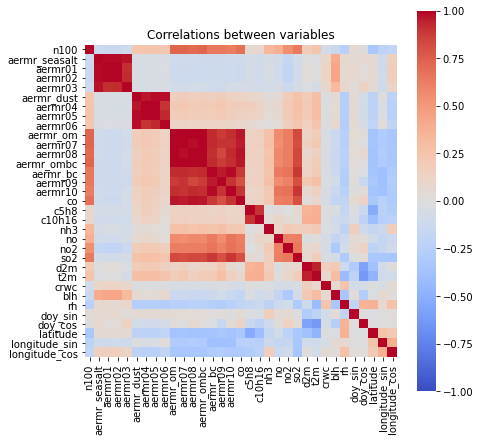

In [44]:
plt.figure(figsize=(7,7))
sns.heatmap(data[['n100']+variables].corr(), 
            xticklabels=['n100']+variables, yticklabels=['n100']+variables, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1)
plt.title('Correlations between variables');

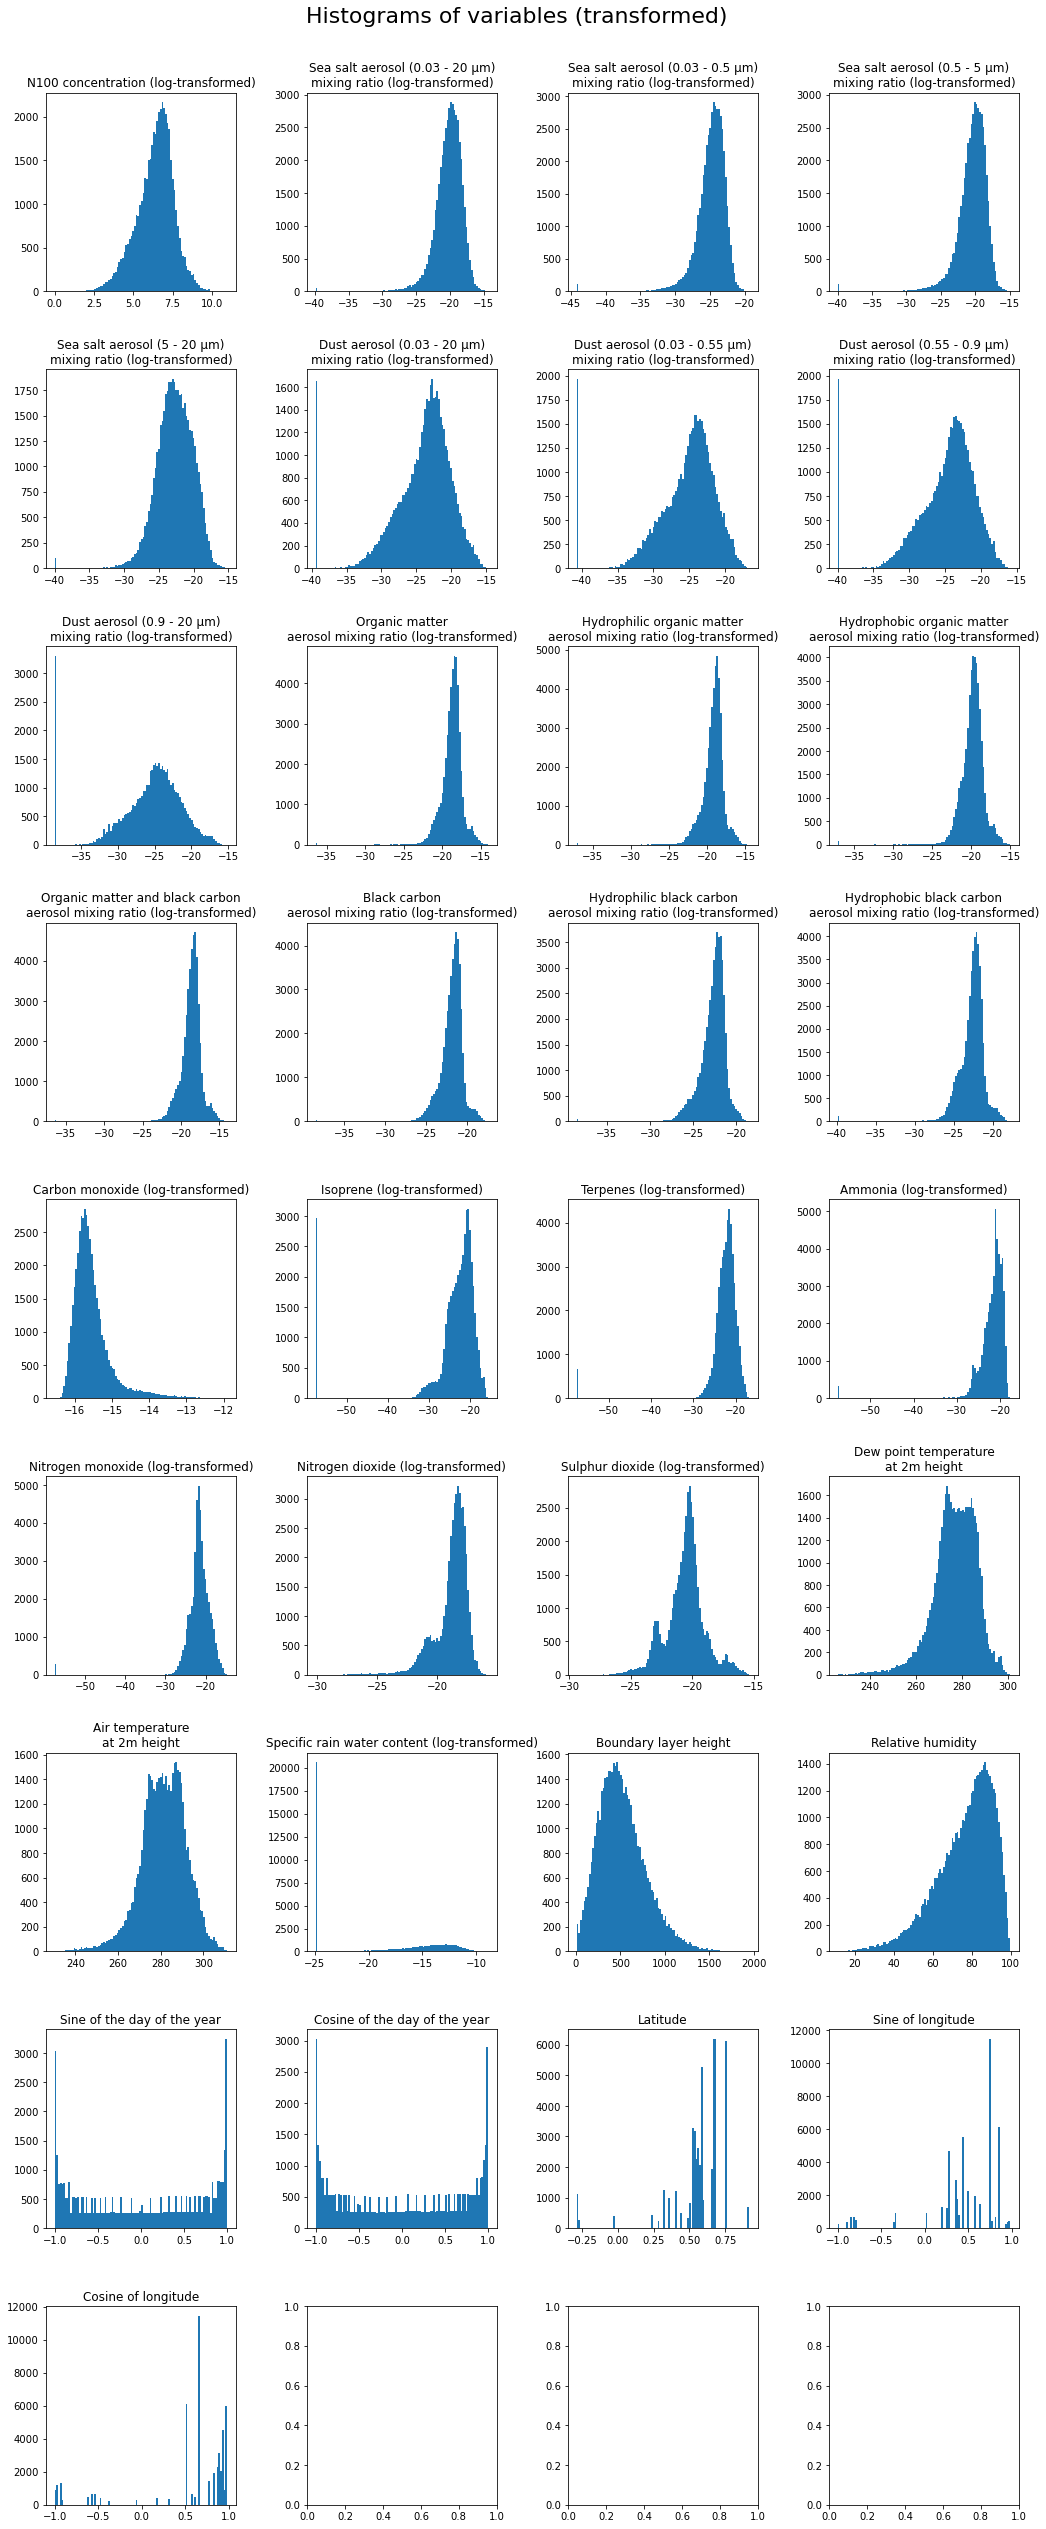

In [45]:
ncols = 4
fig, axes = plt.subplots(9, ncols, figsize=(15,35))
axes = iter(axes)
i = 0

for v in ['n100_log']+transf_vars:
    if i%ncols == 0:
        axis = next(axes)
    ax = axis[i%ncols]
    ax.hist(data[v], bins=100)
    if v[-3:] == 'log':
        ax.set_title(variable_dict[v[:-4]] +' (log-transformed)')
    else:
        ax.set_title(variable_dict[v])
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('Histograms of variables (transformed)', y=1.01, fontsize=22);

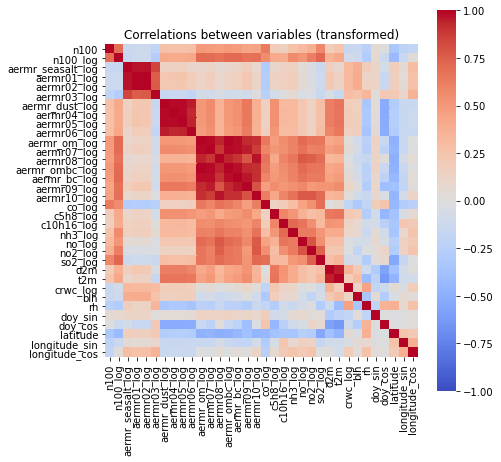

In [46]:
plt.figure(figsize=(7,7))        
sns.heatmap(data[['n100', 'n100_log']+transf_vars].corr(), 
            xticklabels=['n100', 'n100_log']+transf_vars, yticklabels=['n100', 'n100_log']+transf_vars, 
            cmap='coolwarm', cbar=True, square=True, vmin=-1, vmax=1)
plt.title('Correlations between variables (transformed)');

In [47]:
print('Strongest correlations of variables with N100 (before and after transforming):')

for v in variables:
    corr = np.round(pearsonr(data[v], data.n100), 3)
    extra_space = int(corr[0] >= 0)
    offset = 14 - len(v) + extra_space
    
    if v+'_log' in data.columns:
        transf_corr = np.round(pearsonr(data[v+'_log'], data.n100), 3)
        if np.abs(transf_corr[0]) > np.abs(corr[0]):
            print(v, ' '*offset, corr[0], '\t', ' '*extra_space, transf_corr[0], 
                  ' \tcorr higher with transformed data')
        else:
            print(v, ' '*offset, corr[0], '\t', ' '*extra_space, transf_corr[0])
    else:
        print(v, ' '*offset, corr[0])

Strongest correlations of variables with N100 (before and after transforming):
aermr_seasalt   -0.131 	  -0.146  	corr higher with transformed data
aermr01         -0.139 	  -0.118
aermr02         -0.14 	  -0.122
aermr03         -0.109 	  -0.201  	corr higher with transformed data
aermr_dust       0.241 	   0.277  	corr higher with transformed data
aermr04          0.256 	   0.271  	corr higher with transformed data
aermr05          0.244 	   0.268  	corr higher with transformed data
aermr06          0.225 	   0.283  	corr higher with transformed data
aermr_om         0.729 	   0.499
aermr07          0.733 	   0.486
aermr08          0.715 	   0.473
aermr_ombc       0.728 	   0.5
aermr_bc         0.649 	   0.481
aermr09          0.65 	   0.441
aermr10          0.626 	   0.452
co               0.68 	   0.634
c5h8             0.072 	   0.194  	corr higher with transformed data
c10h16           0.078 	   0.155  	corr higher with transformed data
nh3              0.339 	   0.258
no         

In [48]:
print('Strongest correlations of variables with log-transformed N100 (before and after transforming):')

for v in variables:
    corr = np.round(pearsonr(data[v], data.n100_log), 3)
    extra_space = int(corr[0] >= 0)
    offset = 14 - len(v) + extra_space
    
    if v+'_log' in data.columns:
        transf_corr = np.round(pearsonr(data[v+'_log'], data.n100_log), 3)
        if np.abs(transf_corr[0]) > np.abs(corr[0]):
            print(v, ' '*offset, corr[0], '\t', ' '*extra_space, transf_corr[0], 
                  ' \tcorr higher with transformed data')
        else:
            print(v, ' '*offset, corr[0], '\t', ' '*extra_space, transf_corr[0])
    else:
        print(v, ' '*offset, corr[0])

Strongest correlations of variables with log-transformed N100 (before and after transforming):
aermr_seasalt   -0.219 	  -0.154
aermr01         -0.217 	  -0.11
aermr02         -0.219 	  -0.113
aermr03         -0.208 	  -0.269  	corr higher with transformed data
aermr_dust       0.203 	   0.418  	corr higher with transformed data
aermr04          0.216 	   0.41  	corr higher with transformed data
aermr05          0.21 	   0.409  	corr higher with transformed data
aermr06          0.187 	   0.425  	corr higher with transformed data
aermr_om         0.445 	   0.707  	corr higher with transformed data
aermr07          0.456 	   0.698  	corr higher with transformed data
aermr08          0.424 	   0.674  	corr higher with transformed data
aermr_ombc       0.447 	   0.709  	corr higher with transformed data
aermr_bc         0.459 	   0.714  	corr higher with transformed data
aermr09          0.493 	   0.672  	corr higher with transformed data
aermr10          0.425 	   0.684  	corr higher wit